## Homework 4

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# same cols as in hw3 but different random seed
banks = pd.read_csv("bank-full.csv", sep=";")
# select
mycols = ['age', 'job', 'marital', 'education', 'balance', 'housing',
        'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']
dt = banks[mycols].copy()
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [6]:
# forgot to binarize the y
dt.y = (dt.y=="yes").astype(int)

In [7]:
from sklearn.model_selection import train_test_split
X = dt.drop("y", axis=1)
y = dt.y
# train test split in 2 steps
seed = 1
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=seed)

In [8]:
print(X_train.shape, X_val.shape, X_test.shape)

(27126, 14) (9042, 14) (9043, 14)


---

**AUC = exactly P(randomly selected positive example has higher score than randomly selected negative example)**

---

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration` (answer)
- `previous`


---

OK I am not the only one "stupid", here is the answer from FAQ:

Help with understanding: “For each numerical value, use it as score and compute AUC”
When calculating the ROC AUC score using sklearn.metrics.roc_auc_score the function expects two parameters “y_true” and “y_score”. So for each numerical value in the dataframe it will be passed as the “y_score” to the function and the target variable will get passed a “y_true” each time.
Sylvia Schmitt


Normally, one would pass y_true and y_score to the sklearn roc_auc_score function.

---

Another input from LLama: 

"When the feature values are used as a proxy for predicted probabilities, the ROC curve is essentially plotting the performance of a simple threshold-based classifier that uses the feature values to make predictions."

In [9]:
# select numerical features
#numerical = dt.select_dtypes(include="number")
#numerical
# or simply the ones in the answer
myfeatures = ["balance", "day", "duration", "previous"]


In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
# literally using sklearn function and passing the variable as y_score
for feat in myfeatures:
    print(feat, '%.3f' % roc_auc_score(y_train, X_train[feat]))

balance 0.589
day 0.474
duration 0.815
previous 0.599


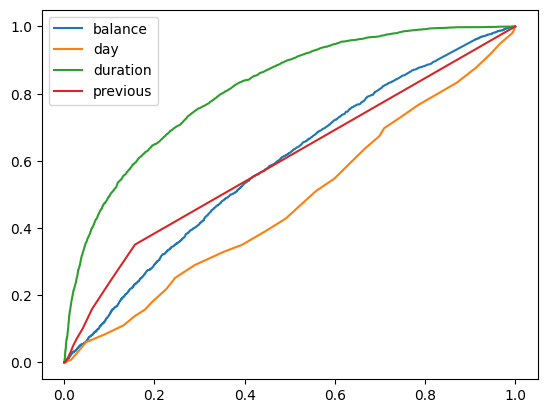

In [11]:
# plot them to understand a bit more
for feat in myfeatures:
    fpr, tpr, thresholds = roc_curve(y_train, X_train[feat])
    plt.plot(fpr,tpr, label = feat)
plt.legend();
    

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89 (kinda? 0.90)
- 0.99


In [12]:
# do it like in the lecture to practice DictVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dict = X_train.to_dict(orient='records') #important: list of dicts, one per record

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict) # outputs np.array

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [13]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [14]:
# predict on val set
val_dict = X_val.to_dict(orient="records")
X_val = dv.transform(val_dict)

In [15]:
y_score = model.predict_proba(X_val)[:, 1] #this is to get the actual score - and we take the proba for pos class

In [16]:
#from sklearn.metrics import auc
roc_auc_score(y_val, y_score)

np.float64(0.9004159581551736)

In [17]:
# do it by hand like in the lecture
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: 
    tp = ((y_score >= t) & (y_val == 1)).sum()
    fp = ((y_score >= t) & (y_val == 0)).sum()
    fn = ((y_score < t) & (y_val == 1)).sum()
    tn = ((y_score < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [18]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

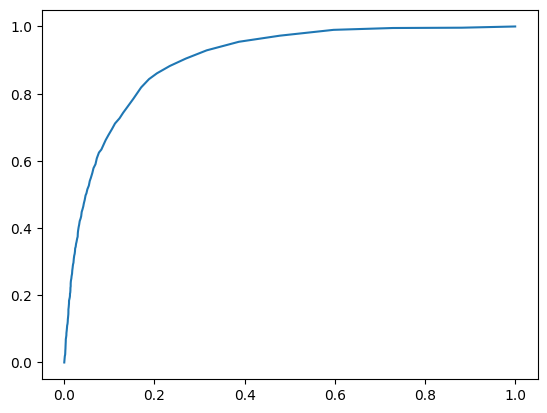

In [19]:
plt.plot(df_scores.fpr, df_scores.tpr);

In [20]:
from sklearn.metrics import auc
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.9001310631616213)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265 (here)
* 0.465
* 0.665
* 0.865


In [21]:
df_scores = df_scores.assign(precision = lambda df : df.tp / (df.tp + df.fp)
                 , recall = lambda df : df.tp / (df.tp + df.fn)
                 )
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,1098,7944,0,0,1.000000,1.000000,0.121433,1.000000
1,0.01,1094,7004,4,940,0.996357,0.881672,0.135095,0.996357
2,0.02,1093,5789,5,2155,0.995446,0.728726,0.158820,0.995446
3,0.03,1087,4745,11,3199,0.989982,0.597306,0.186385,0.989982
4,0.04,1068,3800,30,4144,0.972678,0.478348,0.219392,0.972678
...,...,...,...,...,...,...,...,...,...
96,0.96,30,17,1068,7927,0.027322,0.002140,0.638298,0.027322
97,0.97,25,15,1073,7929,0.022769,0.001888,0.625000,0.022769
98,0.98,21,10,1077,7934,0.019126,0.001259,0.677419,0.019126
99,0.99,11,5,1087,7939,0.010018,0.000629,0.687500,0.010018


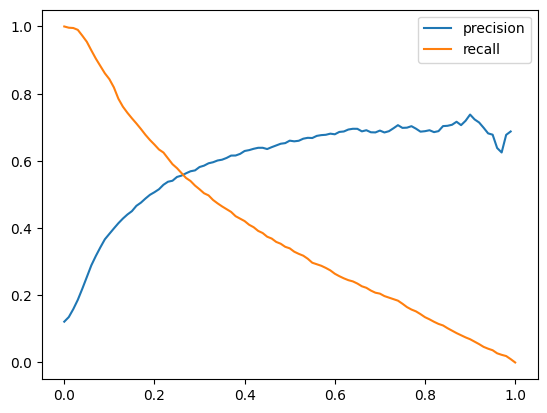

In [22]:
plt.plot(df_scores.threshold, df_scores.precision, label = "precision")
plt.plot(df_scores.threshold, df_scores.recall, label = "recall")
plt.legend();

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22 (max F1)
- 0.42
- 0.62


In [23]:
df_scores.columns

Index(['threshold', 'tp', 'fp', 'fn', 'tn', 'tpr', 'fpr', 'precision',
       'recall'],
      dtype='object')

In [24]:
# another way to add column apart form assign with lambda
df_scores["F1"] = 2*(df_scores.precision*df_scores.recall/(df_scores.precision+df_scores.recall))
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,F1
0,0.00,1098,7944,0,0,1.000000,1.000000,0.121433,1.000000,0.216568
1,0.01,1094,7004,4,940,0.996357,0.881672,0.135095,0.996357,0.237930
2,0.02,1093,5789,5,2155,0.995446,0.728726,0.158820,0.995446,0.273935
3,0.03,1087,4745,11,3199,0.989982,0.597306,0.186385,0.989982,0.313709
4,0.04,1068,3800,30,4144,0.972678,0.478348,0.219392,0.972678,0.358029
...,...,...,...,...,...,...,...,...,...,...
96,0.96,30,17,1068,7927,0.027322,0.002140,0.638298,0.027322,0.052402
97,0.97,25,15,1073,7929,0.022769,0.001888,0.625000,0.022769,0.043937
98,0.98,21,10,1077,7934,0.019126,0.001259,0.677419,0.019126,0.037201
99,0.99,11,5,1087,7939,0.010018,0.000629,0.687500,0.010018,0.019749


In [25]:
# select rows with the named thresholds and select max F1
df_scores.loc[df_scores.threshold.isin([0.02,0.22,0.42,0.62])][["F1"]]#.F1.idxmax()

,F1
2,0.273935
22,0.572860
42,0.493028
62,0.367156


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26



In [26]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [27]:
# code stolen from lecture because lack of time
def train(X, y, C=1.0):
    cat = X.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

def predict(X, dv, model):
    cat = X.to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [39]:
# remember iloc when indexing y (series) by np.array which comes out of KFold!

aucs = []

for train_idx, val_idx in kfold.split(X_train_full):
    X_train = X_train_full.iloc[train_idx]
    y_train = y_train_full.iloc[train_idx].values

    X_val = X_train_full.iloc[val_idx]
    y_val = y_train_full.iloc[val_idx].values

    dv, model = train(X_train, y_train)
    y_pred = predict(X_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [40]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.906 ± 0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [41]:
# code from lecture
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]: #just use those C about which it is asked #[0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(X_train_full):
        X_train = X_train_full.iloc[train_idx]
        X_val = X_train_full.iloc[val_idx]

        y_train = y_train_full.iloc[train_idx].values
        y_val = y_train_full.iloc[val_idx].values

        dv, model = train(X_train, y_train, C=C)
        y_pred = predict(X_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.701 ± 0.009
C=0.001, auc = 0.861 ± 0.007
C=1, auc = 0.906 ± 0.006
